In [1]:
import pandas as pd
import numpy as np
import re

from torch import nn
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import *
import torchvision.models as models


import torch.nn as nn
from transformers import BertModel
from transformers import BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

/home/vscode/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load data and split

In [2]:
training_images_path = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images'
training_dataset =pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train.csv')
testing_dataset = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/test.csv')

training_dataset.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


### Process titles (remove punctuation, stop words, etc)

In [3]:
# remove stop words 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# remove punctuation
import string
punctuations = string.punctuation

# remove numbers
import re
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

# remove special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# remove extra spaces
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text)
    return text

def word_tokenize(text):
    text = text.split()
    return text

# remove stop words
def remove_stop_words(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

# remove all preprocessing
def remove_all_preprocessing(text):
    text = remove_numbers(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = remove_stop_words(text)
    return text

# apply all preprocessing
training_dataset['proc_text'] = training_dataset['title'].apply(lambda x: remove_all_preprocessing(x))
testing_dataset['proc_text'] = testing_dataset['title'].apply(lambda x: remove_all_preprocessing(x))

# get rid of \
training_dataset['proc_text'] = training_dataset['title'].apply(lambda x: x.replace('\\', ''))
testing_dataset['proc_text'] = testing_dataset['title'].apply(lambda x: x.replace('\\', ''))

# lower case
training_dataset['proc_text'] = training_dataset['title'].apply(lambda x: x.lower())
testing_dataset['proc_text'] = testing_dataset['title'].apply(lambda x: x.lower())

training_dataset.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,paper bag victoria secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,double tape m vhb mm x original double foam tape,2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,maling tts canned pork luncheon meat gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,daster batik lengan pendek motif acak campur l...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,nescafe xcxclair latte ml,3648931069


### Check encoding from Advanced BERT model

In [5]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
embeddings = model.encode(training_dataset['title'])
print(embeddings)

[[-0.05237605  0.00266704 -0.0351623  ... -0.0220446   0.03120822
   0.0482746 ]
 [ 0.03168393  0.0207246  -0.01772413 ... -0.02363313  0.00672482
  -0.06600535]
 [-0.02553968  0.02782196  0.01990272 ... -0.0465625  -0.01983832
   0.01210797]
 ...
 [-0.00043891  0.0663081  -0.00434749 ...  0.04577914  0.02965026
  -0.03386611]
 [-0.02243138  0.02246639  0.05454137 ...  0.01867248  0.01682098
   0.00408043]
 [-0.03517014  0.02272914  0.00684843 ... -0.00679976 -0.01856173
  -0.00943737]]


In [6]:
from sklearn.neighbors import NearestNeighbors
from torch.nn import Transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [9]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(embeddings, training_dataset['label_group'])

KNeighborsClassifier(weights='distance')

In [11]:
labels = training_dataset['label_group']


In [29]:
from sklearn.metrics import accuracy_score, f1_score
acc_dict = {}
for k in [1, 2, 3, 5, 10, 25, 50, 100]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Evaluate the performance on the test set
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"k = {k}, Accuracy: {accuracy}")
    print(f"k = {k}, f1: {f1}")
    acc_dict[k] = accuracy

k = 1, Accuracy: 0.498978102189781
k = 1, f1: 0.4807792604732177
k = 2, Accuracy: 0.38306569343065694
k = 2, f1: 0.35805505780994695
k = 3, Accuracy: 0.3375182481751825
k = 3, f1: 0.31057035183397974
k = 5, Accuracy: 0.3005839416058394
k = 5, f1: 0.2676876029260309
k = 10, Accuracy: 0.24744525547445256
k = 10, f1: 0.20623973530342002
k = 25, Accuracy: 0.194014598540146
k = 25, f1: 0.14738019756662057
k = 50, Accuracy: 0.16583941605839417
k = 50, f1: 0.11615758877312352
k = 100, Accuracy: 0.13605839416058393
k = 100, f1: 0.08739168649665359


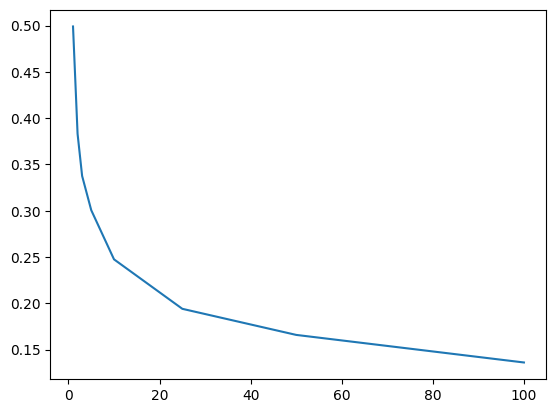

In [30]:
plt.plot(acc_dict.keys(), acc_dict.values())

In [23]:
from sklearn.metrics import accuracy_score, f1_score

In [24]:
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 score:", f1)

Accuracy: 0.38306569343065694
F1 score: 0.35805505780994695


In [ ]:
from sentence_transformers import SentenceTransformer
model_name = 'sentence-transformers/distiluse-base-multilingual-cased-v2'

word_embedding_model = models.Transformer('sentence-transformers/distiluse-base-multilingual-cased-v2', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

#Our sentences we like to encode
# sentences = ['This framework generates embeddings for each input sentence',
#     'Sentences are passed as a list of string.',
#     'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(training_dataset.title)

#Print the embeddings
for sentence, embedding in zip(training_dataset.title, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")
    break

AttributeError: module 'torchvision.models' has no attribute 'Transformer'